# Image Search Take 2: Convolutional Autoencoders FTW

This post continues the discussion of an earlier post [Image search with autoencoders](https://dantegates.github.io/2018/05/01/image-search-with-autoencoders.html) by demonstrating how to use convolutional autoencoders for the task of image retrieval on the CIFAR data set. Since I've already covered the basics of this topic this post will be short and sweet.

Let's quickly recap how searching works with autoencoders.

1. A nueral network with successively smaller and smaller layers followed by successively larger and larger layers is trained to learn to reconstruct its input even though the network is *designed* to lose information (the smaller and smaller layers). In the case of image retrieval the inputs to the network are pixels.
2. The inner most layer of this network contains significantly fewer nodes than the number of pixels. Furthermore all outputs of this layer should be either 0 or 1.
3. The binary output is converted to an $n$ bit integer where $n$ is the size of the hidden layer.
4. These $n$ bit integers are used to determine the similarity between two images.

In my previous post I was able to simplify the step 4 by using the MNIST data set. The simplification was to assign a single $n$-bit code to each image. However, this won't due for a more intricate data set such as CIFAR. In the paper linked above the follow the same exact approach but with the following modification.

Instead of training on each raw image, the autoencoder is trained on "patches" of each image, e.g. each block of $m\times n$ pixels in the image which they illustrated with the following image.

![](./static/retina.png)

This modification allows for each image to be represented by several $n$-bit integers and results in a better search.

Notice carefully however that rather than thinking of this approach as a single network trained on a dataset created by sampling patches from each image we could think about this as a convolutional neural network (CNN), where all layers have a kernel of size $1$ except for the first which has a kernel of size $16\times 16$ and each layer has a number of filters corresponding to the number of hidden nodes in a layer of the network described in the paper. In fact I believe this is how the authors thought of this as well (given one of them is Geoff Hinton) but given the tooling available at the time the paper was written it was easier to modify the data set than train a CNN.

Below is a `keras` implementation of such a CNN and an implementation of using the codes it generates to search over the CIFAR data set.

In [1]:
import keras
import keras.backend as K
from keras.datasets import cifar10
import numpy as np
import numba
import matplotlib.pyplot as plt
import numpy as np
from random import choice

/home/dante/venvs/default/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load the data

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = np.concatenate([X_train, X_test])

In [3]:
X_train.shape

(60000, 32, 32, 3)

In [4]:
X_train[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

In [5]:
def sample_array(X, k):
    return X[np.random.randint(len(X), size=k)]

def show_side_by_side(top, bottom):
    plt.figure(figsize=(20, 4))

    n_top = len(top)
    for i in range(n_top):
        ax = plt.subplot(2, n_top, i+1)
        plt.imshow(top[i], interpolation='bicubic')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    n_bottom = len(bottom)

    for i in range(n_bottom):
        ax = plt.subplot(2, n_bottom, i+1+n_bottom)
        plt.imshow(bottom[i], interpolation='bicubic')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

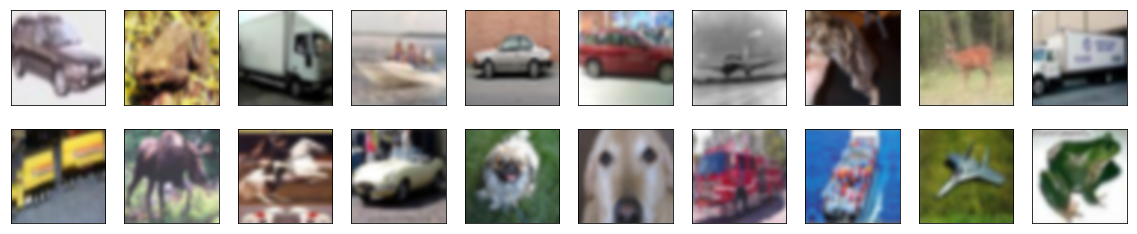

In [6]:
show_side_by_side(sample_array(X_train, 10), sample_array(X_train, 10))

# Training

In [7]:
# scaling to 0 and 1 may seem redundant since the images get normalized anyway
# however if we deal with floats plotting with matplotlib is slightly easier
X_train = X_train / 255.

In [8]:
# normalize the input as described in the paper

mean_pixel_values = X_train.mean(axis=0)
std_all_pixel_values = X_train.std()

# we'll need this later for displaying images with their proper pixel values
def denormalize(X):
    return (X * std_all_pixel_values) + mean_pixel_values

X_train = (X_train - mean_pixel_values) / std_all_pixel_values

In [9]:
denormalize(X_train[0])

array([[[0.23137255, 0.24313725, 0.24705882],
        [0.16862745, 0.18039216, 0.17647059],
        [0.19607843, 0.18823529, 0.16862745],
        ...,
        [0.61960784, 0.51764706, 0.42352941],
        [0.59607843, 0.49019608, 0.4       ],
        [0.58039216, 0.48627451, 0.40392157]],

       [[0.0627451 , 0.07843137, 0.07843137],
        [0.        , 0.        , 0.        ],
        [0.07058824, 0.03137255, 0.        ],
        ...,
        [0.48235294, 0.34509804, 0.21568627],
        [0.46666667, 0.3254902 , 0.19607843],
        [0.47843137, 0.34117647, 0.22352941]],

       [[0.09803922, 0.09411765, 0.08235294],
        [0.0627451 , 0.02745098, 0.        ],
        [0.19215686, 0.10588235, 0.03137255],
        ...,
        [0.4627451 , 0.32941176, 0.19607843],
        [0.47058824, 0.32941176, 0.19607843],
        [0.42745098, 0.28627451, 0.16470588]],

       ...,

       [[0.81568627, 0.66666667, 0.37647059],
        [0.78823529, 0.6       , 0.13333333],
        [0.77647059, 0

## Build the autoencoder

In [10]:
# Define this constant which we'll use to identify the encoding
# layer when we need to pull it out after training
ENCODING_LAYER_NAME = 'encoding'

def binarize(x):
     return x + K.stop_gradient(K.round(x) - x)
Binarize = keras.layers.Lambda(binarize, output_shape=lambda x: x, name=ENCODING_LAYER_NAME)

# This is just one big mess of Conv2D layers followed by BatchNormalization layers -
# except for after the sigmoid activations which would prevent us from getting binary
# values.
# The number of filters correspond to the units in the hidden layers of the 28-bit deep
# encoder in the paper.
autoencoder = keras.models.Sequential([
    # use same padding so we can get back to original size of 32x32
    # valid padding will give us 9x9
    keras.layers.Conv2D(filters=336, kernel_size=16, strides=2, padding='same', activation='relu',
                        input_shape=X_train.shape[1:]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=1024, kernel_size=1, padding='valid', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=512, kernel_size=1, padding='valid', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=1, padding='valid', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=128, kernel_size=1, padding='valid', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=64, kernel_size=1, padding='valid', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=28, kernel_size=1, padding='valid', activation='sigmoid'),
    # don't use batch norm here - must preserve sigmoid activations to get binary encoding
    Binarize,
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=64, kernel_size=1, padding='valid', activation='relu'),    
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=128, kernel_size=1, padding='valid', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=1, padding='valid', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=512, kernel_size=1, padding='valid', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=1024, kernel_size=1, padding='valid', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=336, kernel_size=1, padding='valid', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=3, kernel_size=1, padding='valid', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.UpSampling2D(size=(2, 2)),
])
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 336)       258384    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 336)       1344      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 1024)      345088    
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 1024)      4096      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 512)       524800    
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 16, 512)       2048      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 256)       131328    
__________

In [11]:
autoencoder.compile(loss='mean_squared_error', optimizer='adam')

In [12]:
training_history = autoencoder.fit(
    X_train, X_train,
    epochs=3,
    batch_size=128,
    verbose=1,
    shuffle=True)

Epoch 1/3
60000/60000 [==============================] - 120s 2ms/step - loss: 0.1172
Epoch 2/3
60000/60000 [==============================] - 116s 2ms/step - loss: 0.0804
Epoch 3/3
60000/60000 [==============================] - 117s 2ms/step - loss: 0.0771


## Train results
Now that we have trained the autoencoder, lets randomly sample images from the test set and see how well it can reconstruct them. The output won't be perfect but it should be close enough to let us know we've implemented the autoencoder correctly.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

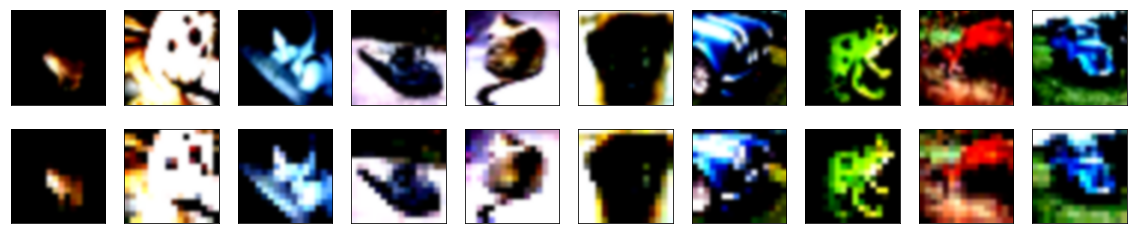

In [13]:
# randomly sample 10 images and look at output
test_sample = sample_array(X_train, k=10)
reconstructions = autoencoder.predict(test_sample)
show_side_by_side(test_sample, reconstructions)

# Semantic hashing

Lastly, we'll take a look at search results given the same query image, but using the "semantic hash table." (implemented in [semantic_hashing.py](https://github.com/dantegates/image-search/blob/master/semantic_hashing.py))

In [14]:
def make_encoder(autoencoder):
    encoding = autoencoder.get_layer(ENCODING_LAYER_NAME).get_output_at(-1)
    # multiply each bit by its corresponding power of 2 to get d-bit int
    def to_int(X):
        X = K.cast(X, 'int32')  # this only works for latent dims <= 32
        latent_dim = K.int_shape(X)[-1]
        Z = 2**K.arange(latent_dim)
        return K.dot(X, K.reshape(Z, (-1, 1)))
    batch_size, width, height, filters = K.int_shape(encoding)
    encoding = keras.layers.Lambda(to_int, output_shape=lambda x: (batch_size, width, height, 1))(encoding)
    encoding = keras.layers.Reshape((width*height,))(encoding)
    encoder = keras.models.Model(inputs=autoencoder.input, outputs=encoding)
    return encoder

encoder = make_encoder(autoencoder)

In [15]:
q = sample_array(X_train, 1)
encoder.predict(q)

array([[165936027, 166976271, 100326283,  62505667, 165927711, 167508927,
        163314623, 162265535, 160168255, 164363583, 162266047, 160168255,
        164362559, 161216959, 167508895,  26197423,  28413250,  62505539,
        129753282,  62636738, 222550831, 234085135,  33225611, 166984607,
         32693131,  99801999,  33225611, 163839807, 164362559, 164362559,
        167508383, 163839279,  61992258,  27105782, 231128369, 164085051,
        112870093,  91900431,  62505539,  62491203,  62505667,  98192143,
        205773615, 222550811, 163839295, 163839295, 164362559, 163314111,
        166919067, 162892146,  60141410, 124940936,  62121026,  62636738,
         62490179,  62637635,  62637762,  73583385, 205758251,  71490329,
        222486331, 163839807, 164362559, 163314111, 161741755, 266530715,
         62761330,  62237042,  61974338,  62603976,  62121538,  60665699,
         62113346, 107113112, 108153485, 222732091, 222797611, 224583483,
        165935423, 163314111, 16383980

In [16]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 336)       258384    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 336)       1344      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 1024)      345088    
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 1024)      4096      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 512)       524800    
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 16, 512)       2048      
__________

In [17]:
import collections
import statistics

import numba
import numpy as np
import tqdm


def search(query, encoder, table, threshold=3, top_n=10):
    query_codes = encoder.predict(query)[0]  # encoder must reshape
    scores = collections.defaultdict(int)
    for query_code in query_codes:
        raw_scores = _score_items(query_code, table, threshold, top_n)
        for item_id, score in raw_scores:
            scores[item_id] += score
    top_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    results = [table.fetch_item(item_id) for item_id, _ in top_scores]
    return results

def _score_items(query_code, table, threshold, top_n):
    item_scores = {}
    # first score each code, then score items stored in each code
    d = _hamming_distance(query_code, table.codes)
    within_threshold = np.argwhere(d <= threshold).reshape(-1)
    code_scores = 2**(3-d[within_threshold])
    for score, code in zip(code_scores, table.codes[within_threshold]):
        for item_id in table.fetch_bucket(code):
            item_score = max(score, item_scores.get(item_id, 0))
            item_scores[item_id] = item_score
    return item_scores.items()

# see,
# https://en.wikipedia.org/wiki/Hamming_distance#Algorithm_example
@numba.vectorize
def _hamming_distance(n1, n2):
    # this number is made of each bit in either n1 or n2
    # but not both
    v = n1 ^ n2
    d = 0
    while v != 0:
        # subtracting 1 clears the least bit, a, in v and sets all bits
        # before a which are cleared by the logical &
        # 2^n = sum(2^m for 0 <= m <= n-1)
        d += 1
        v &= v - 1
    return d


class SemanticHashTable:
    def __init__(self):
        # lookup table for an item (e.g. image) by its ID
        self._items = {}
        # lookup table for list of image IDs by encoding
        self._semantic_hash_table = {}
        
    @property
    def codes(self):
        # numpy array that we can quickly compute hamming distance over
        return np.array(list(self._semantic_hash_table.keys()), dtype='int64')

    def fetch_bucket(self, code):
        return self._semantic_hash_table[code]
    
    def add_item(self, code, item):
        if not code in self._semantic_hash_table:
            self._semantic_hash_table[code] = set()
        item_id = id(item)
        self._items[item_id] = item
        self._semantic_hash_table[code].add(item_id)

    def fetch_item(self, item_id):
        return self._items[item_id]

    def describe(self):
        number_of_buckets = len(self._semantic_hash_table.keys())
        bucket_sizes = [len(v) for v in self._semantic_hash_table.values()]
        median_density = statistics.median(bucket_sizes)
        mean_density = statistics.mean(bucket_sizes)
        min_density = min(bucket_sizes)
        max_density = max(bucket_sizes)
        print('number of buckets:', number_of_buckets)
        print('median density:', median_density)
        print('mean density:', mean_density)
        print('min density:', min_density)
        print('max density:', max_density)

In [18]:
semantic_hash_table = SemanticHashTable()

In [19]:
def populate_table(encoder, items, table):
    codes = encoder.predict(items)
    for item, item_codes in zip(items, codes):
        for code in item_codes:
            table.add_item(code, item)

In [20]:
%time populate_table(encoder, X_train, semantic_hash_table)

CPU times: user 23.7 s, sys: 1.19 s, total: 24.9 s
Wall time: 41.1 s


In [21]:
semantic_hash_table.describe()

number of buckets: 16448
median density: 36.0
mean density: 509.46163667315176
min density: 1
max density: 23396


CPU times: user 18.9 s, sys: 0 ns, total: 18.9 s
Wall time: 18.9 s


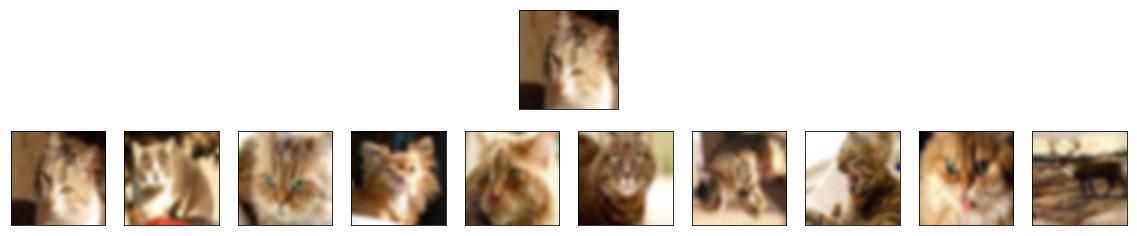

In [27]:
q = sample_array(X_train, k=1)
%time res = search(q, encoder, semantic_hash_table)
res = np.array(res)
show_side_by_side(denormalize(q), denormalize(res))

CPU times: user 20 s, sys: 0 ns, total: 20 s
Wall time: 20 s


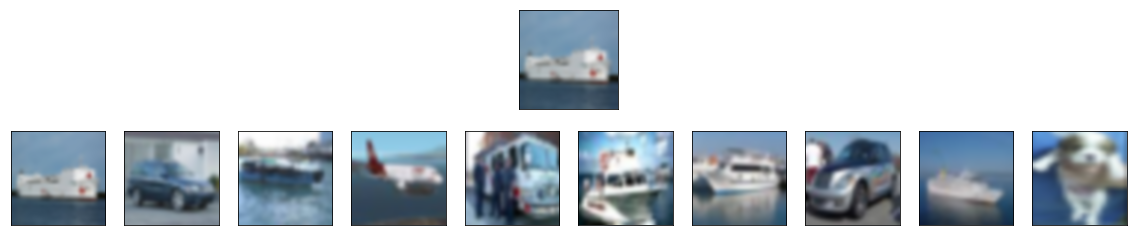

In [33]:
q = sample_array(X_train, k=1)
%time res = search(q, encoder, semantic_hash_table)
res = np.array(res)
show_side_by_side(denormalize(q), denormalize(res))

CPU times: user 19.4 s, sys: 0 ns, total: 19.4 s
Wall time: 19.3 s


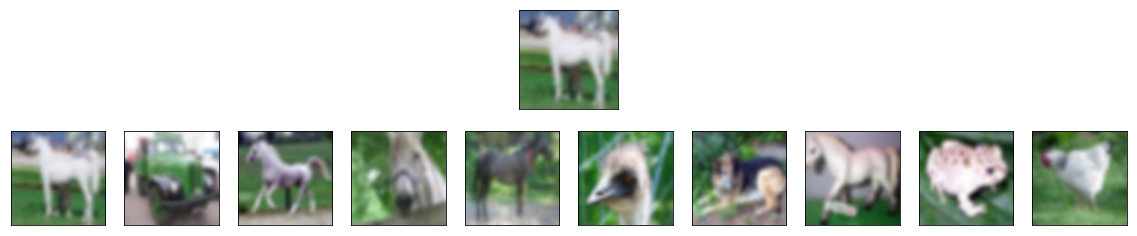

In [35]:
q = sample_array(X_train, k=1)
%time res = search(q, encoder, semantic_hash_table)
res = np.array(res)
show_side_by_side(denormalize(q), denormalize(res))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


CPU times: user 25.7 s, sys: 674 µs, total: 25.7 s
Wall time: 25.7 s


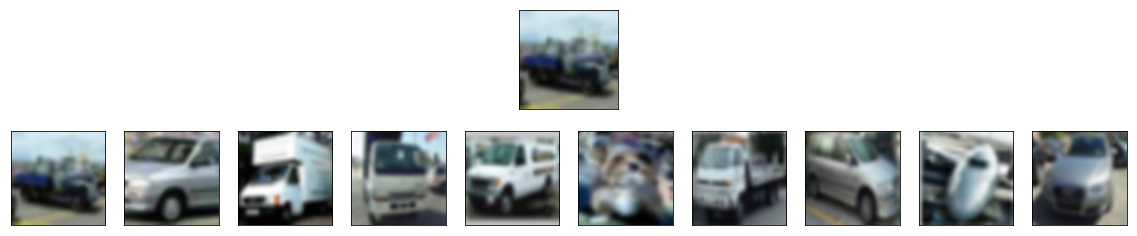

In [37]:
q = sample_array(X_train, k=1)
%time res = search(q, encoder, semantic_hash_table)
res = np.array(res)
show_side_by_side(denormalize(q), denormalize(res))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


CPU times: user 13 s, sys: 8.65 ms, total: 13 s
Wall time: 13 s


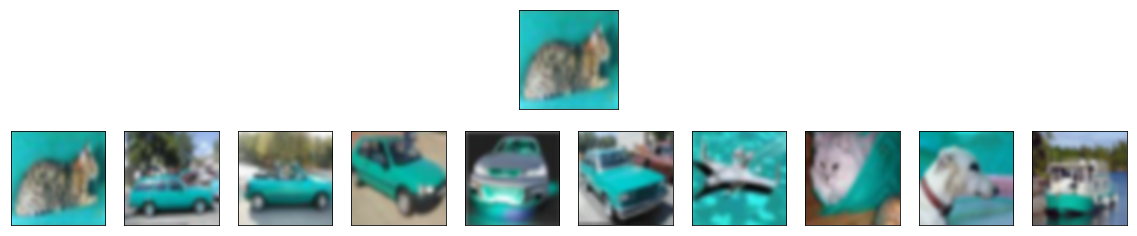

In [39]:
q = sample_array(X_train, k=1)
%time res = search(q, encoder, semantic_hash_table)
res = np.array(res)
show_side_by_side(denormalize(q), denormalize(res))